In [1]:
%matplotlib notebook
import pandas as pd
from preprocess import Audio_Processor
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')

In [5]:
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
classes = [None] * 50
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
h_classes = ['Human & Animal', 'Interacting Materials']

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [7]:
df = ps.get_mfccs(dataset,
                  blocksize=blocksize, 
                  overlap=overlap,
                  n_mels=128,
                  power_melgram=2.0,
                  decibel_gram=True
                 )

Epoch 1/1
2/2 [==============================] - 0s 44ms/step - loss: 1.3368


In [8]:
mfcc = pd.concat(df['mfcc'].values, keys=list(range(len(df))))
mfcc.head()

0    1    2    3    4    5    6    7    8    9    10   11   12
0 0 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  3 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  4 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [9]:
print(mfcc.shape)
quant = ps.quantize_mfccs(mfcc)

(1111104, 13)
Init 1/3 with method: k-means++
Inertia for init 1/3: 367060.839385
Init 2/3 with method: k-means++
Inertia for init 2/3: 366683.679510
Init 3/3 with method: k-means++
Inertia for init 3/3: 367009.537073
Minibatch iteration 1/2800: mean batch inertia: 3.100848, ewa inertia: 3.100848 
Minibatch iteration 2/2800: mean batch inertia: 3.063231, ewa inertia: 3.098075 
Minibatch iteration 3/2800: mean batch inertia: 3.043523, ewa inertia: 3.094053 
Minibatch iteration 4/2800: mean batch inertia: 3.054557, ewa inertia: 3.091141 
Minibatch iteration 5/2800: mean batch inertia: 3.033295, ewa inertia: 3.086876 
Minibatch iteration 6/2800: mean batch inertia: 3.045605, ewa inertia: 3.083833 
Minibatch iteration 7/2800: mean batch inertia: 3.038648, ewa inertia: 3.080502 
Minibatch iteration 8/2800: mean batch inertia: 3.058549, ewa inertia: 3.078883 
Minibatch iteration 9/2800: mean batch inertia: 3.012279, ewa inertia: 3.073972 
Minibatch iteration 10/2800: mean batch inertia: 3.02

Minibatch iteration 99/2800: mean batch inertia: 2.997672, ewa inertia: 2.974163 
Minibatch iteration 100/2800: mean batch inertia: 2.975562, ewa inertia: 2.974266 
Minibatch iteration 101/2800: mean batch inertia: 2.963701, ewa inertia: 2.973487 
Minibatch iteration 102/2800: mean batch inertia: 2.948542, ewa inertia: 2.971648 
Minibatch iteration 103/2800: mean batch inertia: 2.957286, ewa inertia: 2.970589 
Minibatch iteration 104/2800: mean batch inertia: 2.981890, ewa inertia: 2.971422 
Minibatch iteration 105/2800: mean batch inertia: 2.971987, ewa inertia: 2.971464 
Minibatch iteration 106/2800: mean batch inertia: 2.960520, ewa inertia: 2.970657 
Minibatch iteration 107/2800: mean batch inertia: 2.974953, ewa inertia: 2.970974 
Minibatch iteration 108/2800: mean batch inertia: 2.968944, ewa inertia: 2.970824 
Minibatch iteration 109/2800: mean batch inertia: 2.971189, ewa inertia: 2.970851 
Minibatch iteration 110/2800: mean batch inertia: 2.967475, ewa inertia: 2.970602 
Minib

In [10]:
quant.shape

(2000, 2048)

In [11]:
quant

label,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
5,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
6,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,41.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,17.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X = quant
y_h = pd.Series(dataset['h_target'])
y_l = pd.Series(dataset['target'])

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                        X, y_l, test_size=0.20, random_state=42)

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

params = {
          'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
          'gamma': ('auto', 'scale'),
          'decision_function_shape': ('ovo', 'ovr')
         }

svm = SVC(probability=True, max_iter=1000)

clf = GridSearchCV(svm, params, cv=5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('auto', 'scale'), 'decision_function_shape': ('ovo', 'ovr')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.38


<IPython.core.display.Javascript object>


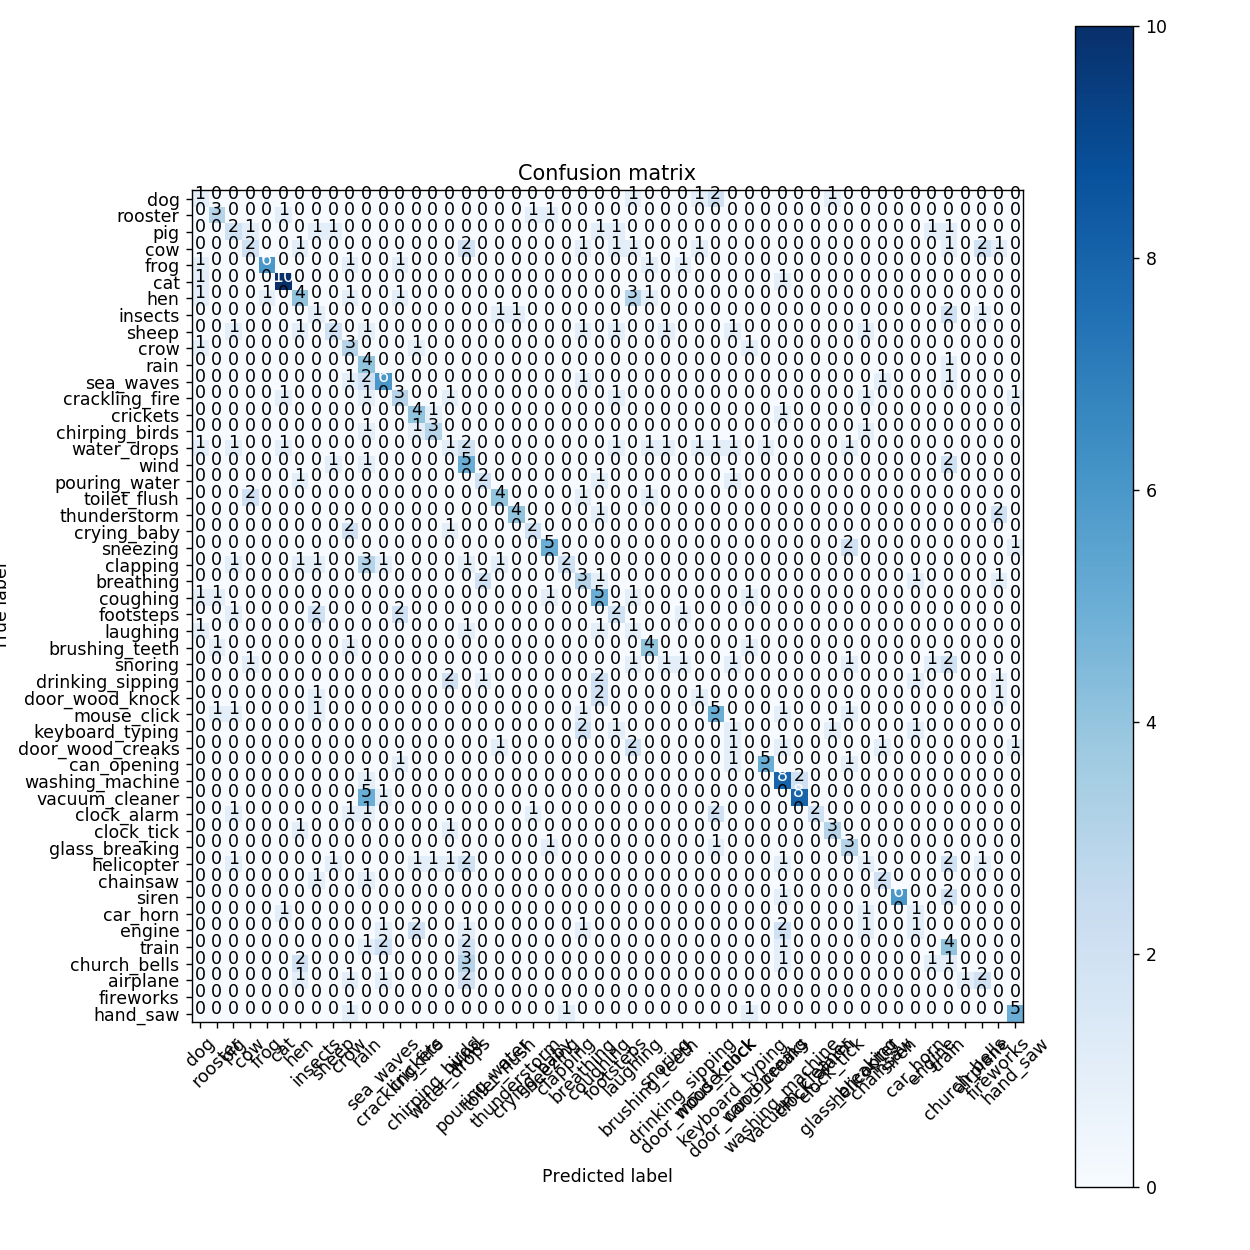

Confusion matrix, without normalization
[[1 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 5]]


In [43]:
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve

pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)

In [15]:
pca_2d = pca.transform(X)

<IPython.core.display.Javascript object>


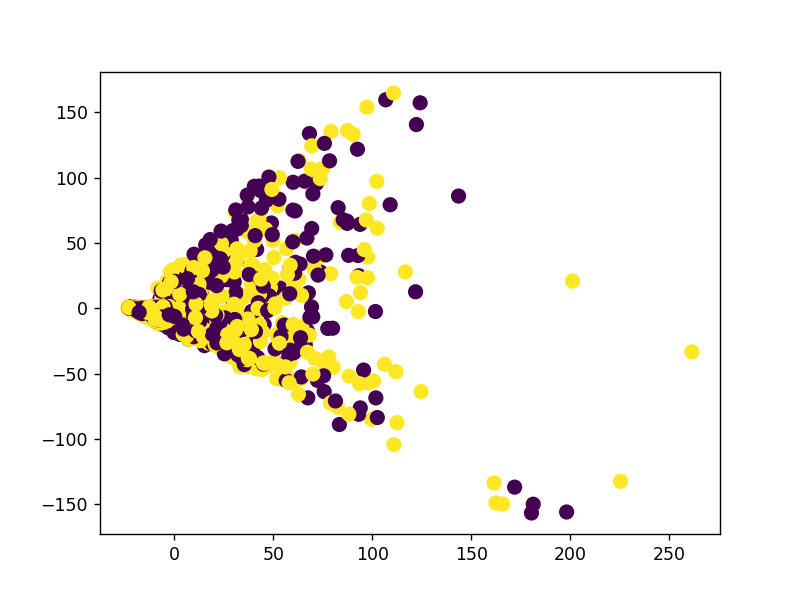

In [16]:
fig = plt.figure()
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=y_h, s=60)
plt.show()

<IPython.core.display.Javascript object>


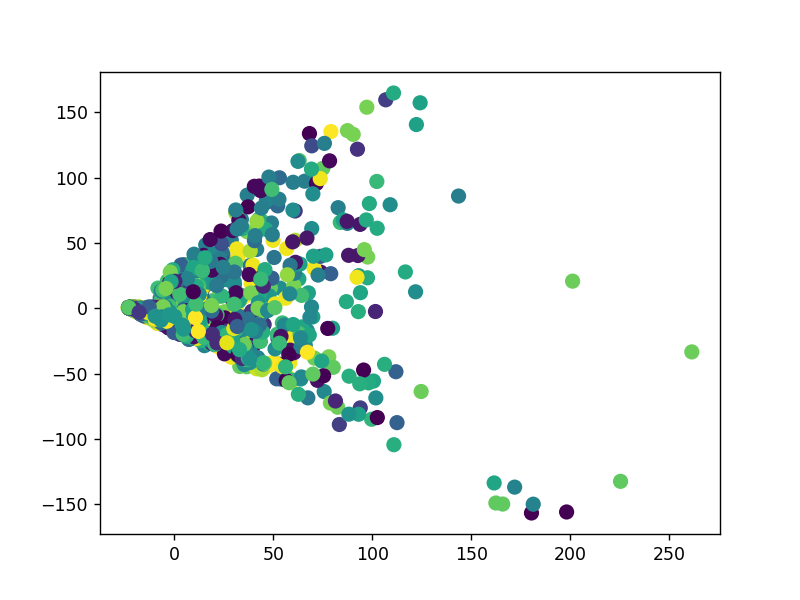

In [17]:
fig = plt.figure()
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=y_l, s=60)
plt.show()

## Animal + Human

In [18]:
pca = PCA(n_components=2).fit(X[y_h == 1])
pca_2d = pca.transform(X[y_h == 1])

<IPython.core.display.Javascript object>


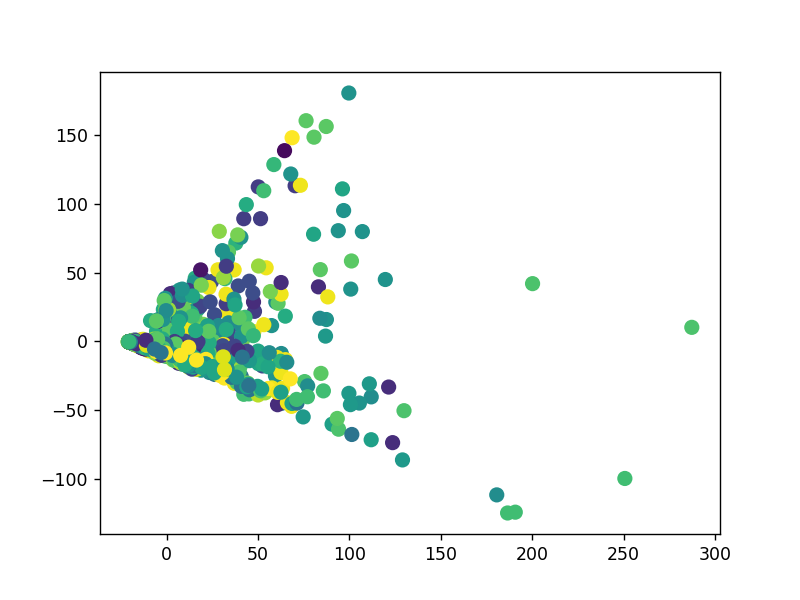

In [19]:
fig = plt.figure()
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=y_l[y_h == 1].values, s=60)
plt.show()

## Interacting Elements

In [20]:
pca = PCA(n_components=2).fit(X[y_h == 0])
pca_2d = pca.transform(X[y_h == 0])

<IPython.core.display.Javascript object>


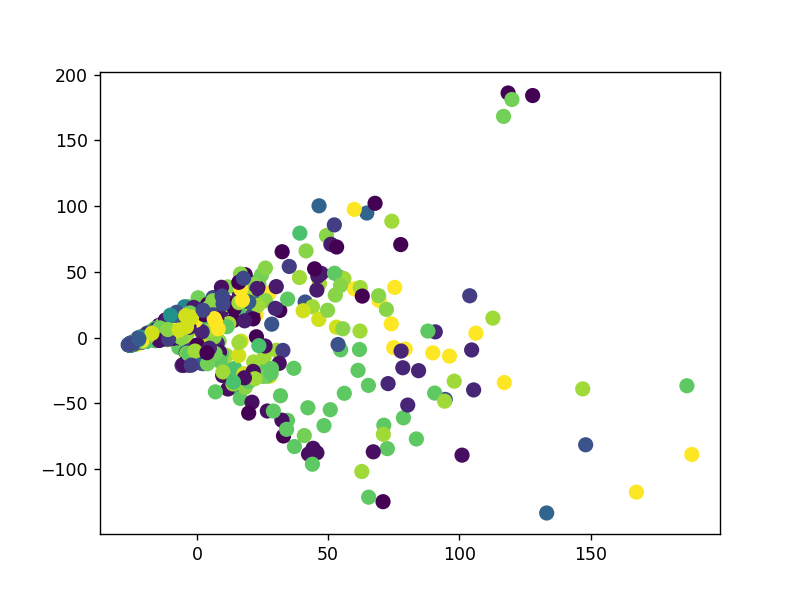

In [21]:
fig = plt.figure()
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=y_l[y_h == 0].values, s=60)
plt.show()

# ICA

In [22]:
from sklearn.decomposition import FastICA as ICA
ica = ICA(n_components=2).fit(X)

In [23]:
ica_2d = ica.transform(X)

<IPython.core.display.Javascript object>


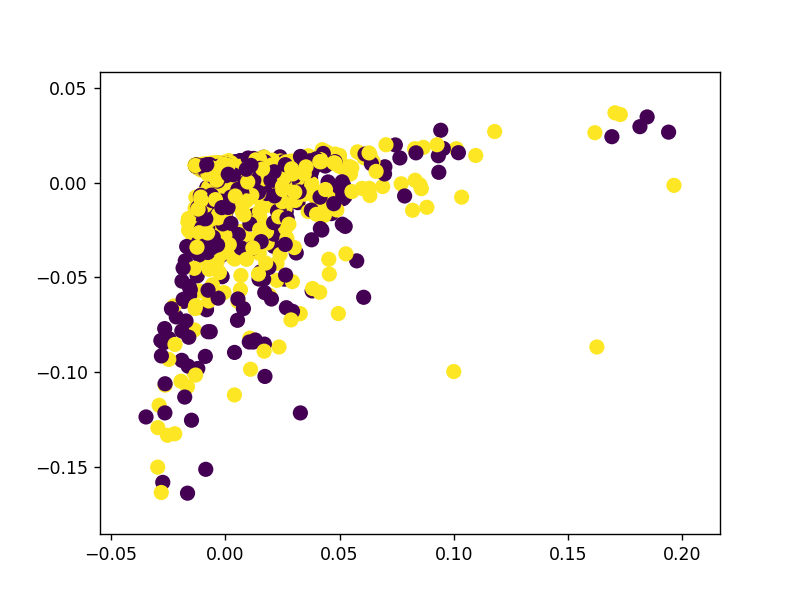

In [24]:
fig = plt.figure()
plt.scatter(ica_2d[:,0], ica_2d[:,1], c=y_h, s=60)
plt.show()

<IPython.core.display.Javascript object>


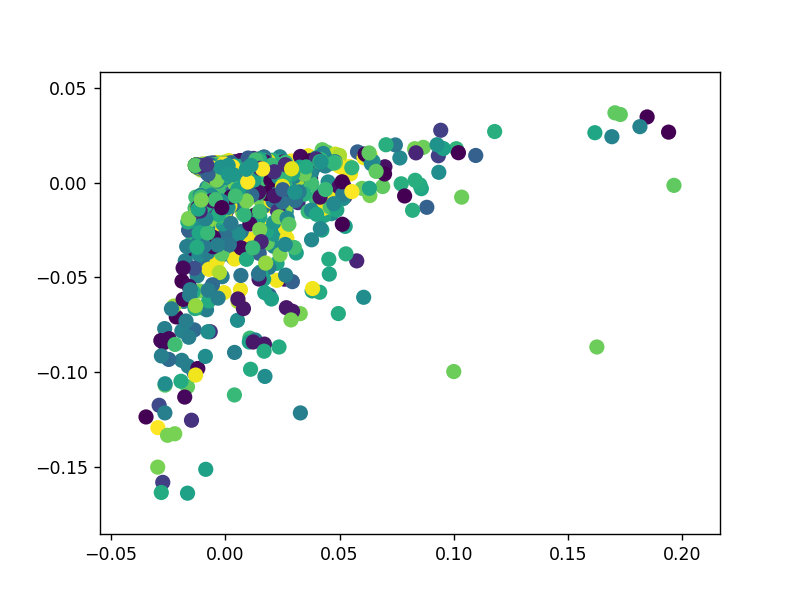

In [25]:
fig = plt.figure()
plt.scatter(ica_2d[:,0], ica_2d[:,1], c=y_l, s=60)
plt.show()

# SVD

In [26]:
from sklearn.decomposition import TruncatedSVD as SVD
svd = SVD(n_components=2).fit(X)

In [27]:
svd_2d = svd.transform(X)

<IPython.core.display.Javascript object>


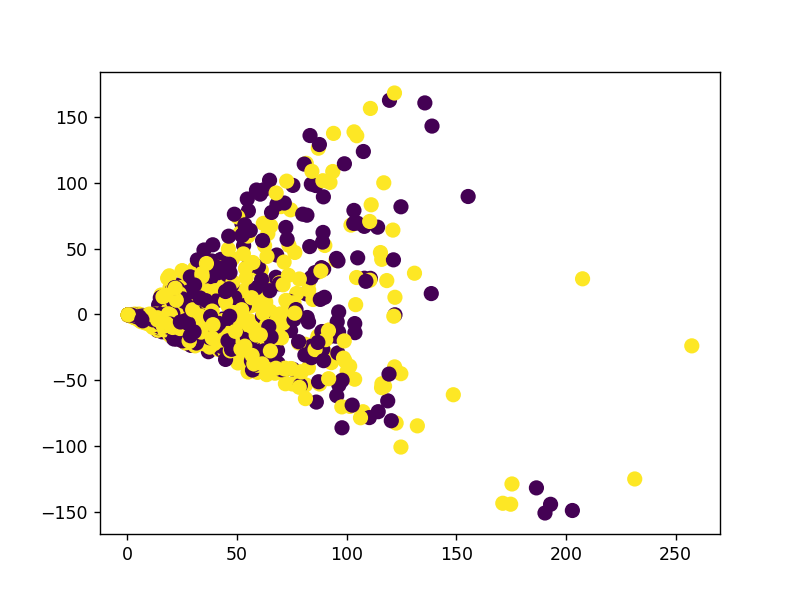

In [28]:
fig = plt.figure()
plt.scatter(svd_2d[:,0], svd_2d[:,1], c=y_h, s=60)
plt.show()

<IPython.core.display.Javascript object>


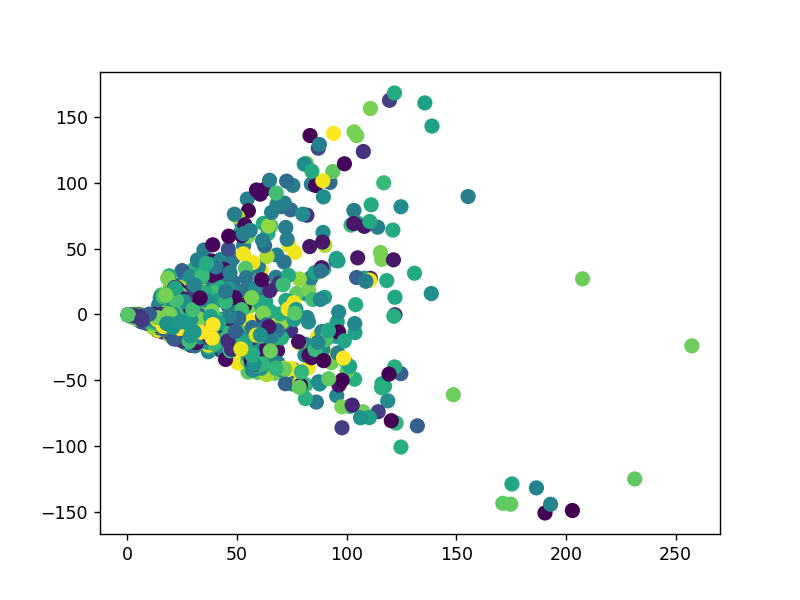

In [29]:
fig = plt.figure()
plt.scatter(svd_2d[:,0], svd_2d[:,1], c=y_l, s=60)
plt.show()

# LDA

In [30]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.preprocessing import minmax_scale
X_scale = pd.DataFrame(minmax_scale(X))
X_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,0.215278,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,...,0.0,0.333333,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.2,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,0.033333,0.000000,0.0,0.0,0.0,0.0,0.2,0.000000,0.166667,0.0,...,0.0,0.000000,0.0,0.090909,0.0,0.0,0.000000,0.083333,0.0,0.230769


In [31]:
lda = LDA(n_components=2).fit(X_scale)

In [32]:
lda_2d = lda.transform(X_scale)

<IPython.core.display.Javascript object>


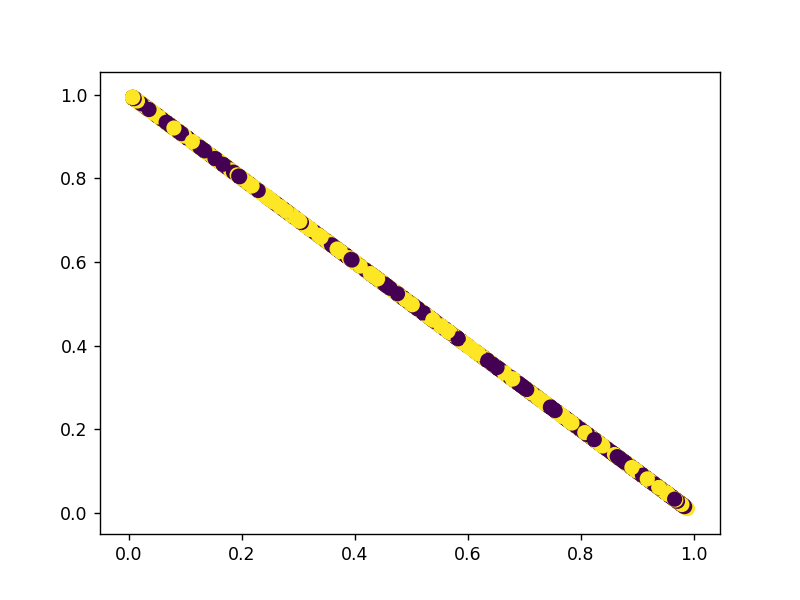

In [33]:
fig = plt.figure()
plt.scatter(lda_2d[:,0], lda_2d[:,1], c=y_h, s=60)
plt.show()

<IPython.core.display.Javascript object>


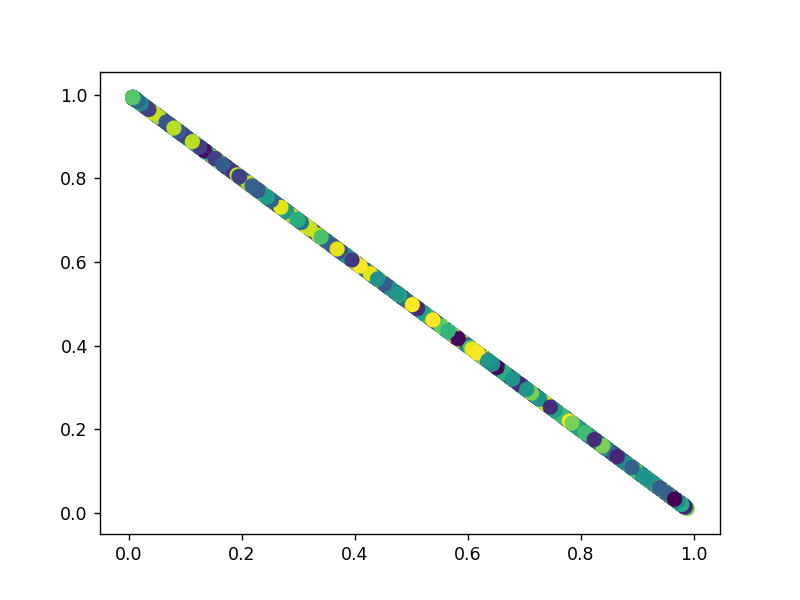

In [34]:
fig = plt.figure()
plt.scatter(lda_2d[:,0], lda_2d[:,1], c=y_l, s=60)
plt.show()